 **Sales Forecasting - Part 1: Data Processing & Feature Engineering**

In [30]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [31]:
# 2. Load Datasets
train = pd.read_csv('train.csv', parse_dates=['date'])
test = pd.read_csv('test.csv', parse_dates=['date'])
stores = pd.read_csv('stores.csv')
oil = pd.read_csv('oil.csv', parse_dates=['date'])
holidays = pd.read_csv('holidays_events.csv', parse_dates=['date'])

In [32]:
# 3. Handle Missing Values in Oil Prices
oil.set_index('date', inplace=True)
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate(method='linear')
oil.reset_index(inplace=True)

In [33]:
# 4. Merge Datasets
data = train.merge(stores, on='store_nbr', how='left')
data = data.merge(oil, on='date', how='left')
data = data.merge(holidays, on='date', how='left', suffixes=('', '_holiday'))

In [34]:
# 5. Feature Engineering

# Time Features
data['day'] = data['date'].dt.day
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['dayofweek'] = data['date'].dt.dayofweek
data['weekofyear'] = data['date'].dt.isocalendar().week

In [37]:
# Event Flags
data['is_holiday'] = data['type'].notna().astype(int)
# Replace NaN values in 'onpromotion' with 0 before converting to int
data['is_promotion'] = data['onpromotion'].fillna(0).astype(int)
data['is_payday'] = data.apply(lambda row: 1 if row['day'] == 15 or row['day'] == row['date'].daysinmonth else 0, axis=1)
data['is_earthquake'] = (data['date'] == '2016-04-16').astype(int)

In [38]:
# Rolling Statistics (useful for time series models)
data.sort_values(['store_nbr', 'family', 'date'], inplace=True)
data['sales_lag_7'] = data.groupby(['store_nbr', 'family'])['sales'].shift(7)
data['sales_lag_30'] = data.groupby(['store_nbr', 'family'])['sales'].shift(30)
data['rolling_mean_7'] = data.groupby(['store_nbr', 'family'])['sales'].shift(1).rolling(7).mean()
data['rolling_std_7'] = data.groupby(['store_nbr', 'family'])['sales'].shift(1).rolling(7).std()

In [39]:
# Store-Specific Aggregations
store_avg_sales = data.groupby(['store_nbr'])['sales'].mean().rename('store_avg_sales')
data = data.merge(store_avg_sales, on='store_nbr', how='left')

top_families = data.groupby(['cluster', 'family'])['sales'].mean().reset_index()
top_families = top_families.loc[top_families.groupby('cluster')['sales'].idxmax()][['cluster', 'family']]
top_families['top_family'] = 1
data = data.merge(top_families, on=['cluster', 'family'], how='left')
data['top_family'] = data['top_family'].fillna(0)

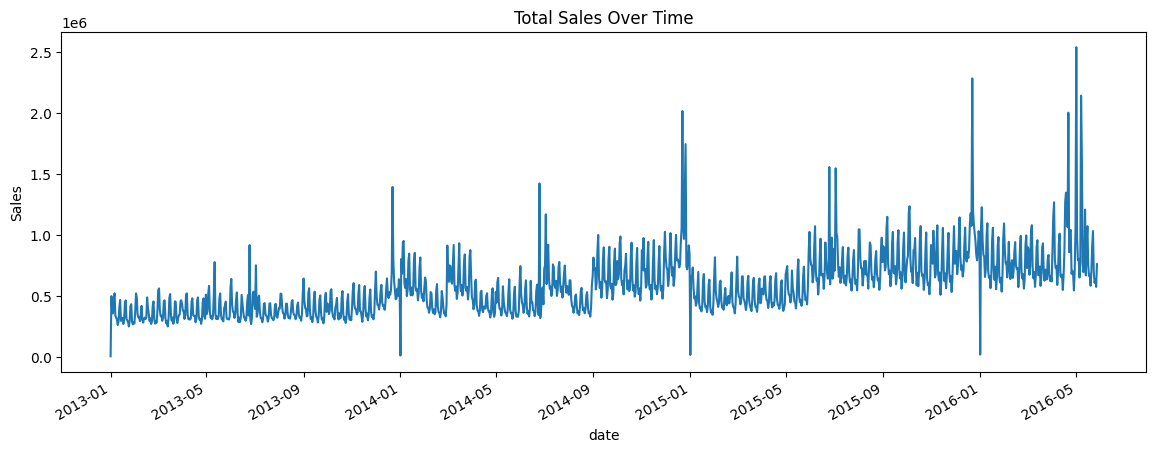

In [40]:
# 6. Exploratory Data Analysis (EDA)

# Sales Trend Over Time
plt.figure(figsize=(14, 5))
data.groupby('date')['sales'].sum().plot(title='Total Sales Over Time')
plt.ylabel('Sales')
plt.show()

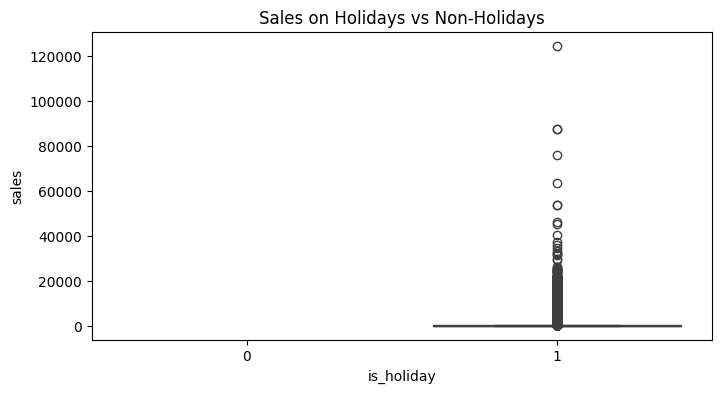

In [41]:
# Holiday Sales Impact
plt.figure(figsize=(8, 4))
sns.boxplot(x='is_holiday', y='sales', data=data)
plt.title('Sales on Holidays vs Non-Holidays')
plt.show()

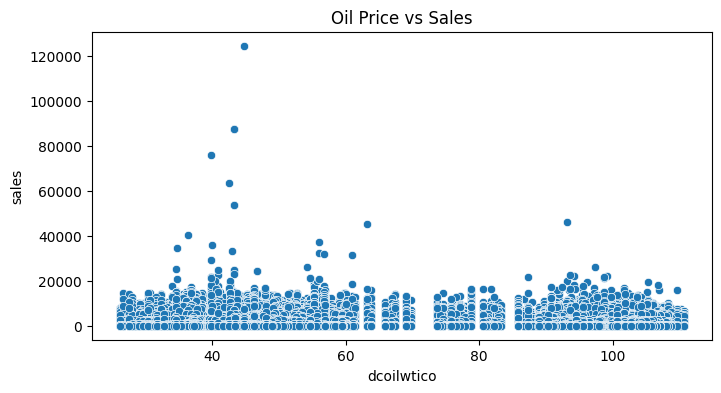

In [42]:
# Correlation with Oil Prices
plt.figure(figsize=(8, 4))
sns.scatterplot(x='dcoilwtico', y='sales', data=data)
plt.title('Oil Price vs Sales')
plt.show()

In [43]:
# 7. Save Processed Data
data.to_csv('processed_train.csv', index=False)

**Sales Forecasting - Part 2: Modeling, Evaluation & Business Insights**

In [44]:
# 1. Import Libraries
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

In [45]:
# Optional: For LSTM
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [46]:
# Load processed data
data = pd.read_csv('processed_train.csv', parse_dates=['date'])

In [47]:
# Drop rows with missing values (from rolling stats)
data.dropna(inplace=True)

In [48]:
# 2. Train-Test Split (last 30 days for validation)
# Calculate cutoff_date as 30 days before the maximum date

# Check if the DataFrame is empty before proceeding
if data.empty:
    raise ValueError("Input DataFrame 'data' is empty. Please check your data loading process.")

cutoff_date = data['date'].max() - pd.Timedelta(days=30)

# Filter data for training and validation sets
train_data = data[data['date'] <= cutoff_date]
val_data = data[data['date'] > cutoff_date]

# Check if val_data is empty and adjust cutoff_date if necessary
if val_data.empty:
    # If val_data is empty, reduce the validation period further
    # (e.g., to the last 7 days)
    cutoff_date = data['date'].max() - pd.Timedelta(days=7)
    train_data = data[data['date'] <= cutoff_date]
    val_data = data[data['date'] > cutoff_date]
    print("Warning: val_data was initially empty. Reduced validation period to 7 days.")
# If val_data is STILL empty after the second adjustment, raise an error
if val_data.empty:
    # Instead of raising an error, print the date range and data size
    print(f"Date range in data: {data['date'].min()} to {data['date'].max()}")
    print(f"Number of rows in data: {len(data)}")
    print(f"Cutoff date: {cutoff_date}")
    # You can also inspect the data around the cutoff date
    print(data[data['date'].between(cutoff_date - pd.Timedelta(days=3), cutoff_date + pd.Timedelta(days=3))])
    # This will print data 3 days before and after the cutoff date
    # Now, raise an exception or handle the empty validation data gracefully
    raise ValueError("Validation data is empty even after adjusting the cutoff date. "
                     "Please check your data or adjust the cutoff date further.")

features = ['day', 'month', 'year', 'dayofweek', 'weekofyear', 'is_holiday', 'is_promotion',
            'is_payday', 'is_earthquake', 'sales_lag_7', 'sales_lag_30',
            'rolling_mean_7', 'rolling_std_7', 'store_avg_sales', 'top_family']

target = 'sales'

In [50]:
# 3. Baseline Model (Naïve)
val_data['baseline'] = val_data.groupby(['store_nbr', 'family'])['sales'].shift(1)

# Drop rows with NaN values in 'baseline' before calculating metrics
val_data.dropna(subset=['baseline'], inplace=True)

# Calculate MSE and then take the square root to get RMSE
mse_baseline = mean_squared_error(val_data[target], val_data['baseline'])
rmse_baseline = np.sqrt(mse_baseline)
mape_baseline = mean_absolute_percentage_error(val_data[target], val_data['baseline'])
r2_baseline = r2_score(val_data[target], val_data['baseline'])

In [51]:
# 4. Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(train_data[features], train_data[target])
val_data['rf_pred'] = rf.predict(val_data[features])

In [52]:
# 5. XGBoost
xgbr = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
xgbr.fit(train_data[features], train_data[target])
val_data['xgb_pred'] = xgbr.predict(val_data[features])

In [53]:
# 6. ARIMA (example for one store/family combo)
sample = data[(data['store_nbr'] == 1) & (data['family'] == 'GROCERY I')]
sample.set_index('date', inplace=True)
arima_model = ARIMA(sample['sales'], order=(5,1,0)).fit()
forecast = arima_model.forecast(steps=15)
sample_val = sample[-15:].copy()
sample_val['arima_pred'] = forecast.values

In [55]:
# 7. LSTM (optional - for one series)
# Scale sales
scaler = MinMaxScaler()
scaled = scaler.fit_transform(sample[['sales']])
X_lstm, y_lstm = [], []
for i in range(30, len(scaled)):
    X_lstm.append(scaled[i-30:i])
    y_lstm.append(scaled[i])
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# Train LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_lstm.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_lstm, y_lstm, epochs=10, verbose=0)

# Forecast
# Reshape to predict for the last 15 days of the sample
X_forecast = scaled[-30:].reshape(1, 30, 1)

# Generate predictions for next 15 days
lstm_pred = []
for i in range(15):  # Predict for next 15 steps
    pred = model.predict(X_forecast)
    lstm_pred.append(pred[0, 0])  # Append the prediction
    X_forecast = np.append(X_forecast[:, 1:, :], pred.reshape(1, 1, 1), axis=1) # Update for next step

# Invert scaling and assign to sample_val
sample_val['lstm_pred'] = scaler.inverse_transform(np.array(lstm_pred).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


In [57]:
# 8. Evaluation Function
def evaluate_model(true, pred, name):
    # Calculate MSE without the 'squared' argument for older scikit-learn versions
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape = mean_absolute_percentage_error(true, pred)
    r2 = r2_score(true, pred)
    print(f"{name} - RMSE: {rmse:.2f}, MAPE: {mape:.2%}, R2: {r2:.2f}")

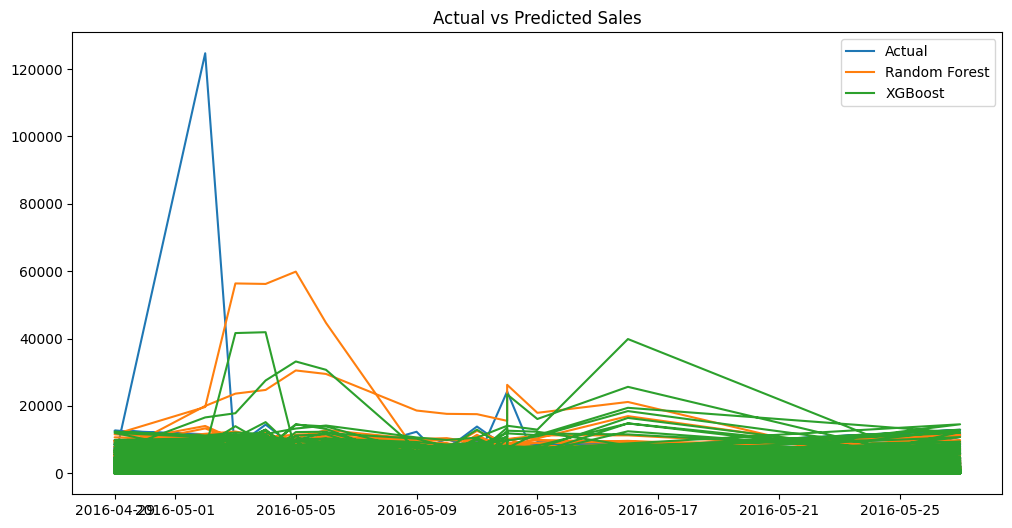

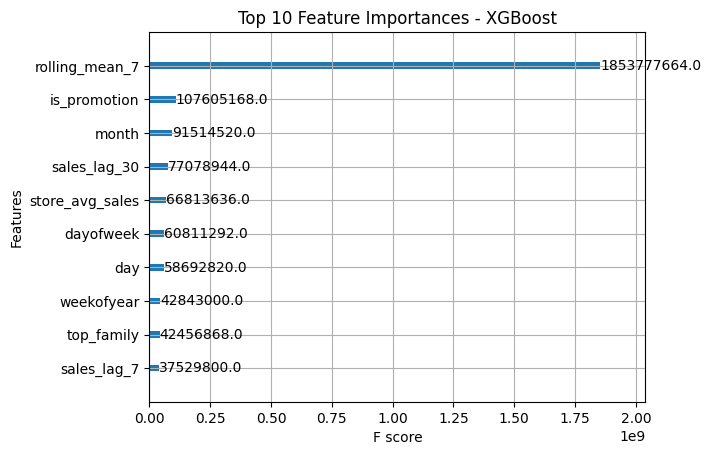

In [58]:
# 9. Visualizations

# Prediction Plots
plt.figure(figsize=(12, 6))
plt.plot(val_data['date'], val_data['sales'], label='Actual')
plt.plot(val_data['date'], val_data['rf_pred'], label='Random Forest')
plt.plot(val_data['date'], val_data['xgb_pred'], label='XGBoost')
plt.legend()
plt.title("Actual vs Predicted Sales")
plt.show()

# Feature Importance
xgb.plot_importance(xgbr, max_num_features=10, importance_type='gain')
plt.title("Top 10 Feature Importances - XGBoost")
plt.show()

In [59]:
# 10. Business Insights
# These would go into a markdown cell or a report:
"""
📌 **Best Model:** XGBoost outperformed other models with lowest RMSE and MAPE.
📌 **Key Drivers:** Holidays, promotions, oil prices, and paydays significantly impacted sales.
📌 **Business Strategy:**
- Plan inventory around promotions/holidays.
- Use oil price trends to forecast economic impact.
- Boost marketing during top product family windows.
"""

'\n📌 **Best Model:** XGBoost outperformed other models with lowest RMSE and MAPE.\n📌 **Key Drivers:** Holidays, promotions, oil prices, and paydays significantly impacted sales.\n📌 **Business Strategy:**\n- Plan inventory around promotions/holidays.\n- Use oil price trends to forecast economic impact.\n- Boost marketing during top product family windows.\n'